In [1]:
%matplotlib inline
import theano
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
sns.set_style('whitegrid')

In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)

In [3]:
Y = Y.astype('float64')

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

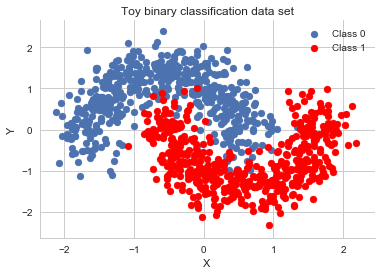

In [5]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [6]:
X_train.shape

(500, 2)

In [7]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden)
    init_2 = np.random.randn(n_hidden, n_hidden)
    init_out = np.random.randn(n_hidden)

    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

# Trick: Turn inputs and outputs into shared variables.
# It's still the same thing, but we can later change the values of the shared variable
# (to switch in the test-data later) and pymc3 will just use the new data.
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

In [8]:
with neural_network:
    nutstrace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_2_out, w_1_2, w_in_1]
100%|██████████| 3000/3000 [03:52<00:00, 12.92it/s]
There were 232 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.651692949328, but should be close to 0.8. Try to increase the number of tuning steps.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.682274841411, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
pm.summary(nutstrace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
w_in_1__0_0,0.123930,1.330869,0.116547,-2.460931,2.930068,9.0,1.137070
w_in_1__0_1,-0.493261,1.431399,0.130625,-3.050534,2.414883,23.0,1.107352
w_in_1__0_2,-0.391219,1.359743,0.118412,-2.887345,2.457370,51.0,0.999820
w_in_1__0_3,0.265870,1.427571,0.128061,-2.439405,3.031381,24.0,1.018467
w_in_1__0_4,-0.135690,1.161102,0.101015,-2.902407,2.339875,18.0,1.051387
w_in_1__1_0,0.071497,0.948036,0.068116,-2.057060,2.555026,67.0,1.013077
w_in_1__1_1,-0.023531,0.901718,0.072519,-2.280693,2.076487,81.0,1.000335
w_in_1__1_2,0.053893,1.127319,0.087329,-2.456869,2.609779,67.0,1.008521
w_in_1__1_3,0.047101,0.900319,0.075818,-2.516146,1.791953,12.0,1.055726
w_in_1__1_4,-0.035805,0.962708,0.082209,-2.360810,2.205260,47.0,1.000899


In [10]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

Average Loss = 151.75: 100%|██████████| 30000/30000 [00:28<00:00, 1057.53it/s]
Finished [100%]: Average Loss = 151.75


In [11]:
advitrace = approx.sample(draws=5000)

In [12]:
pm.summary(advitrace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
w_in_1__0_0,-0.521386,0.112502,0.001786,-0.741013,-0.297054
w_in_1__0_1,0.122723,0.319251,0.004560,-0.504744,0.743053
w_in_1__0_2,-0.543037,0.113075,0.001731,-0.769624,-0.328908
w_in_1__0_3,3.255195,0.487644,0.006504,2.279137,4.182791
w_in_1__0_4,-0.464174,0.162645,0.002485,-0.789237,-0.154705
w_in_1__1_0,0.362184,0.177318,0.002432,0.008508,0.706695
w_in_1__1_1,-0.153209,0.440645,0.006077,-0.998433,0.710622
w_in_1__1_2,0.328326,0.182822,0.002778,-0.036471,0.671428
w_in_1__1_3,0.814828,0.332562,0.004819,0.187650,1.495967
w_in_1__1_4,0.262358,0.236041,0.003509,-0.200934,0.738899


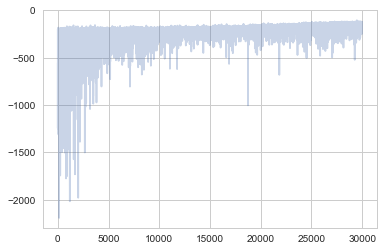

In [13]:
plt.plot(-inference.hist, alpha=.3)

In [14]:
ann_input.set_value(X_test)
ann_output.set_value(Y_test)
with neural_network:
    ppc = pm.sample_ppc(advitrace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1593.05it/s]


In [15]:
pred = ppc['out'].mean(axis=0) > 0.5

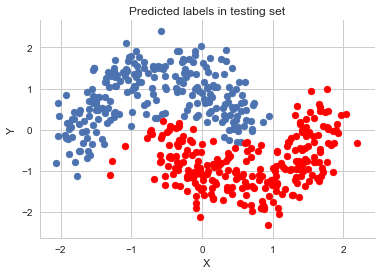

In [16]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [17]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 95.19999999999999%


In [18]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [19]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)
with neural_network:
    ppc_grid = pm.sample_ppc(advitrace ,500)

100%|██████████| 500/500 [00:02<00:00, 227.28it/s]


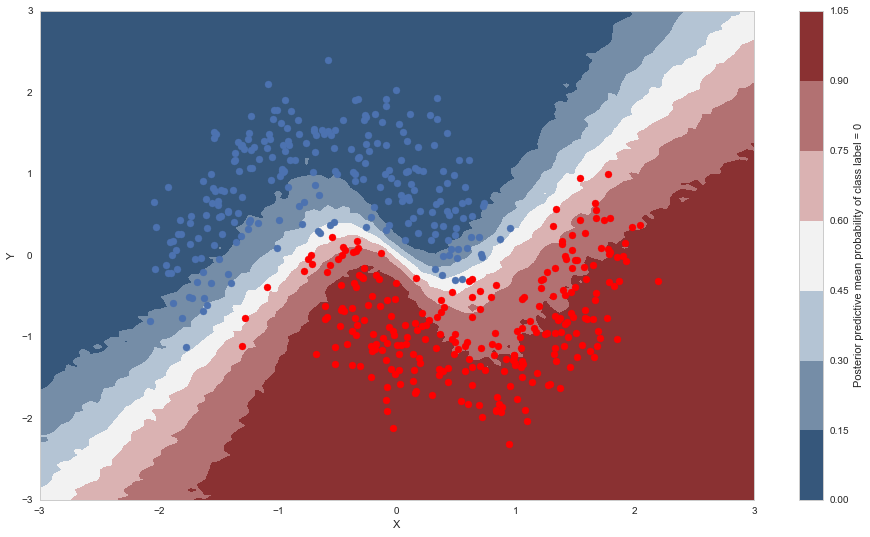

In [20]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc_grid['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

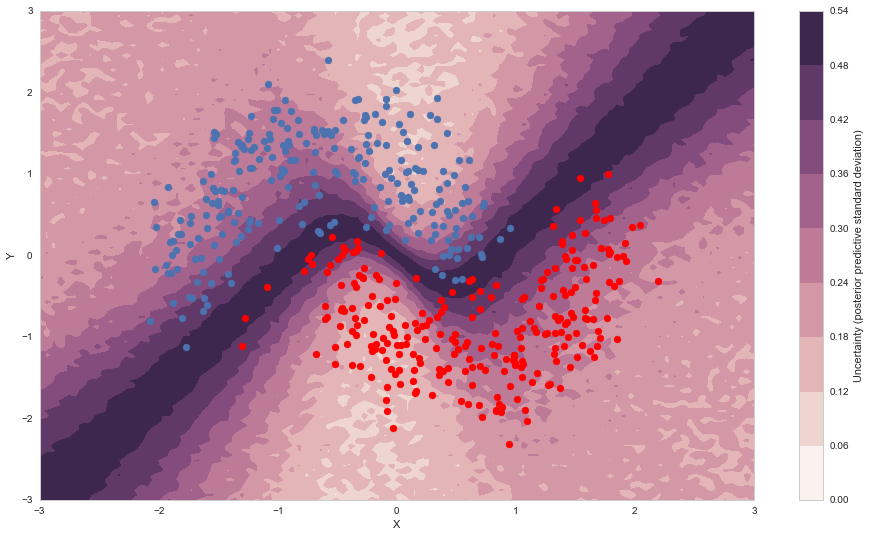

In [21]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc_grid['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [22]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx_mb = pm.fit(40000, method=pm.ADVI())

Average Loss = 162.17: 100%|██████████| 40000/40000 [00:28<00:00, 1425.03it/s]
Finished [100%]: Average Loss = 162.06


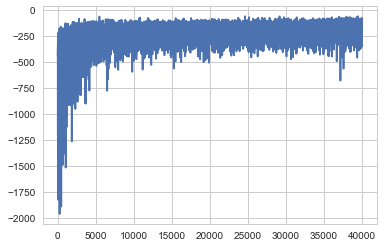

In [23]:
plt.plot(-approx_mb.hist)